### Important notes

Data Augmentation and transformation is a critical step in training deep learning algos, specially for small datasets.

Since the images have different sizes, we need to resize all images to a **pre-determined size**.

We also need to update the labels, during data transformation and augmentation.

Here we'll develop our own functions for updating the labels, for the following transformations:

- horizontal flipping
- vertical flipping
- translation
- resizing



In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# lets plot some images with the location of the fovea
import numpy as np
from PIL import Image, ImageDraw

# fix a seed
np.random.seed(2019)

# plot params
plt.rcParams["figure.figsize"] = (15, 9)
plt.subplots_adjust(wspace=0, hspace=0.3)
nrows, ncols = 2, 3

<Figure size 1080x648 with 0 Axes>

In [5]:
path2data = "./data/DF-Annotation-Training400"
path2labels = os.path.join(path2data, "Training400", "Fovea_location.xlsx")
labels_df = pd.read_excel(path2labels, index_col="ID")
labels_df.head()

,imgName,Fovea_X,Fovea_Y
ID,,,
1,A0001.jpg,1182.264278,1022.018842
2,A0002.jpg,967.754046,1016.946655
3,A0003.jpg,1220.206714,989.944033
4,A0004.jpg,1141.140888,1000.594955
5,A0005.jpg,1127.371832,1071.109440


In [6]:
def load_img_label(labels_df, id_):
    img_name = labels_df["imgName"]
    if img_name[id_][0] == "A":
        prefix = "AMD"
    else:
        prefix = "Non-AMD"

    fullpath2img = os.path.join(path2data, "Training400", prefix, img_name[id_])
    img = Image.open(fullpath2img)
    x = labels_df["Fovea_X"][id_]
    y = labels_df["Fovea_Y"][id_]
    label = (x, y)
    return img, label

In [7]:
# to show the image and label as bounding box
def show_img_label(img, label, w_h=(50, 50), thickness=2):
    w, h = w_h
    cx, cy = label
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx - w / 2, cy - h / 2), (cx + w / 2, cy + h / 2)), outline="green", width=thickness)
    plt.imshow(np.asarray(img), cmap="gray")

In [8]:
import torchvision.transforms.functional as tf

In [9]:
def resize_img_label(image, label=(0., 0.), target_size=(256, 256)):
    w_orig, h_orig = image.size
    w_target, h_target = target_size
    cx, cy = label
    image_new = tf.resize(image, target_size)
    label_new = cx / w_orig * w_target, cy / h_orig * h_target
    return image_new, label_new

(2124, 2056) (1182.26427759023, 1022.01884158854)
(256, 256) (142.4951295024006, 127.25526432230848)


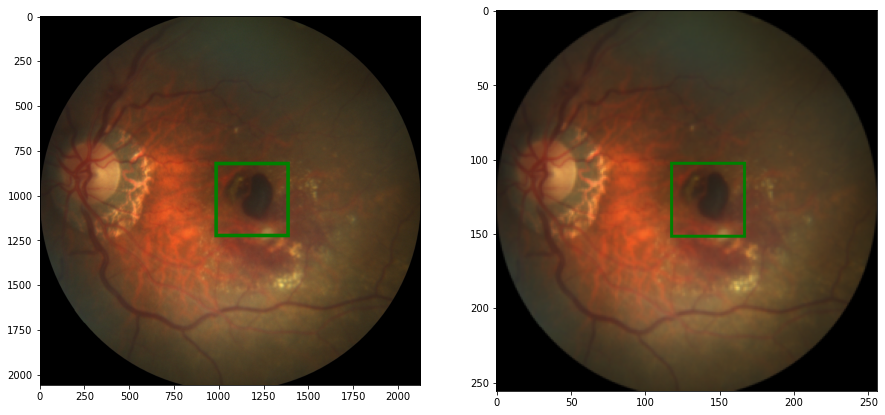

In [10]:
img, label = load_img_label(labels_df, 1)
print(img.size, label)

img_r, label_r = resize_img_label(img, label)
print(img_r.size, label_r)

plt.subplot(1, 2, 1)
show_img_label(img, label, w_h=(420, 420), thickness=20)

plt.subplot(1, 2, 2)
show_img_label(img_r, label_r)

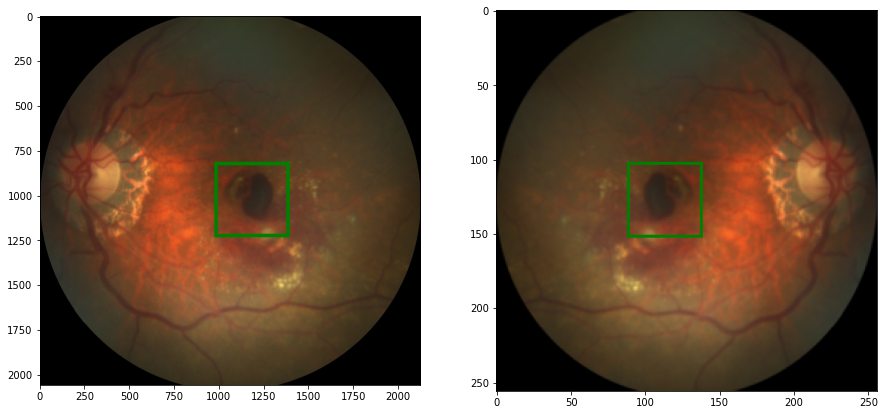

In [11]:
def random_hflip(img, label):
    w, _ = img.size
    x, y = label

    image = tf.hflip(img)
    label = w - x, y
    return image, label

img, label = load_img_label(labels_df, 1)
img_r, label_r = resize_img_label(img, label)
img_fh, label_fh = random_hflip(img_r, label_r)

plt.subplot(1, 2, 1)
show_img_label(img, label, w_h=(420, 420), thickness=20)

plt.subplot(1, 2, 2)
show_img_label(img_fh, label_fh)

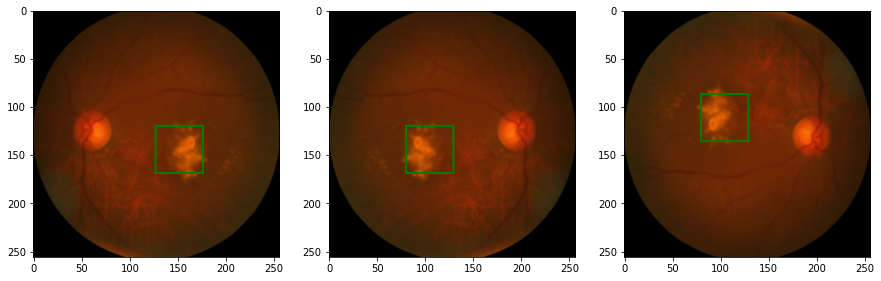

In [12]:
def random_vflip(img, label):
    w, h = img.size
    x, y = label

    img = tf.vflip(img)
    label = x, w - y
    return img, label

img, label = load_img_label(labels_df, 7)
img_r, label_r = resize_img_label(img, label)
img_fh, label_fh = random_hflip(img_r, label_r)
img_fv, label_fv = random_vflip(img_fh, label_fh)

plt.subplot(1, 3, 1)
show_img_label(img_r, label_r)

plt.subplot(1, 3, 2)
show_img_label(img_fh, label_fh)

plt.subplot(1, 3, 3)
show_img_label(img_fv, label_fv)


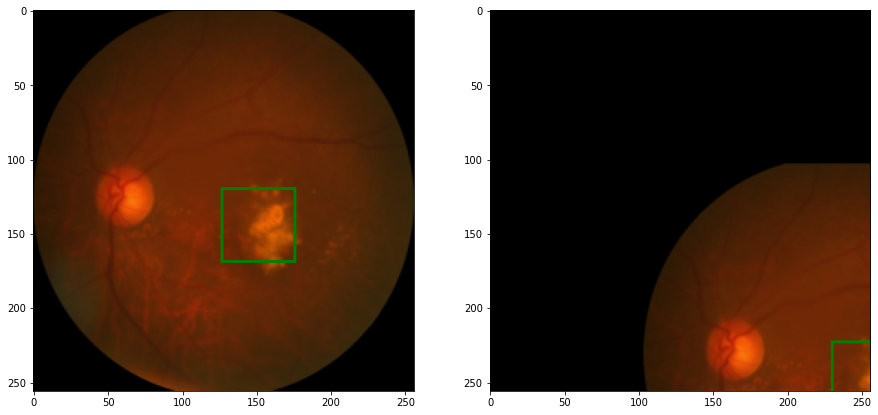

In [13]:
def random_shift(image, label, max_translate=(0.2, 0.2)):
    w, h = image.size
    max_t_w, max_t_h = max_translate
    cx, cy = label
    trans_coef = np.random.rand()*2 - 1
    w_t = int(trans_coef * max_t_w * w)
    h_t = int(trans_coef * max_t_h * h)
    img = tf.affine(image, translate=(w_t, h_t), shear=0, angle=0, scale=1)
    label = cx + w_t, cy + h_t
    return img, label

img, label = load_img_label(labels_df, 7)
img_r, label_r = resize_img_label(img, label)
# img_fh, label_fh = random_hflip(img_r, label_r)
# img_fv, label_fv = random_vflip(img_fh, label_fh)
img_t, label_t = random_shift(img_r, label_r, max_translate=(.5, .5))

plt.subplot(1, 2, 1)
show_img_label(img_r, label_r)

plt.subplot(1, 2, 2)
show_img_label(img_t, label_t)



In [14]:
import random

np.random.seed(0)
random.seed(0)

# composing multiple transformations
def transformer(image, label, params):
    image, label = resize_img_label(image, label, params["target_size"])

    if random.random() < params["p_hflip"]:
        image, label = random_hflip(image, label)
    if random.random() < params["p_vflip"]:
        image, label = random_vflip(image, label)
    if random.random() < params["p_shift"]:
        image, label = random_shift(image, label, params["max_translate"])
    
    image = tf.to_tensor(image)
    
    return image, label


image, label = load_img_label(labels_df, 10)

params = {
    "target_size": (256, 256),
    "p_hflip": 1.0,
    "p_vflip": 1.0,
    "p_shift": 1.0,
    "max_translate": (0.2, 0.2),
}

img_t, label_t = transformer(image, label, params)


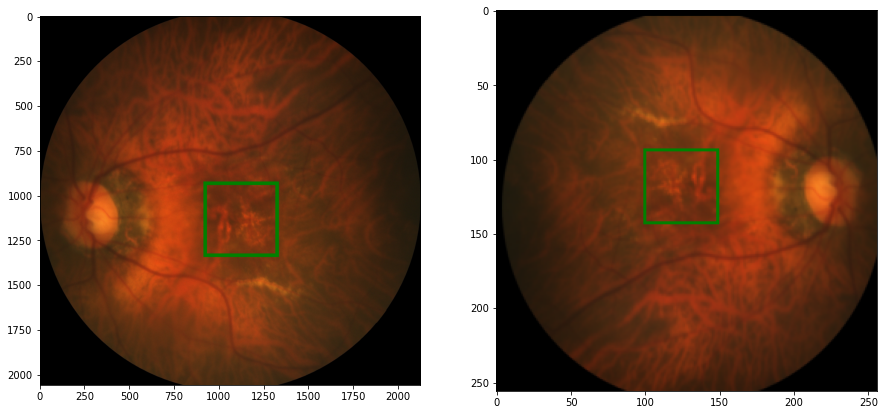

In [15]:
plt.subplot(1, 2, 1)
show_img_label(image, label, w_h=(420, 420), thickness=20)

plt.subplot(1, 2, 2)
show_img_label(tf.to_pil_image(img_t), label_t)

### Important Notes 2

Affine transformations can perform rotation, shearing, translation and scaling.

You should pay attention to the order of the functions when building custom transformations. It's better to resize the image first to reduce the computational complexity.

Moreover, converting to tensors using tf.to_tensor goes at the end and scale PIL images, reshaping into the formate [C, W, H].

It's a good practice to put the transformations as params, as we can choose the probability that each transformation occur.

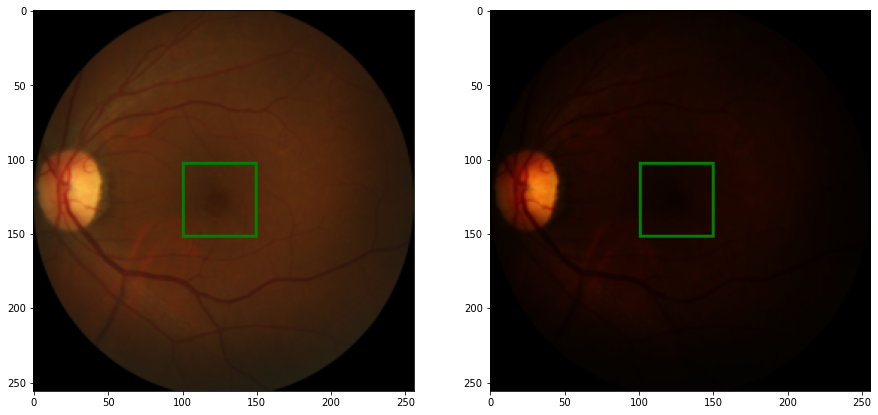

In [16]:
# performing more transformations
image, label = load_img_label(labels_df, 30)

img_r, label_r = resize_img_label(image, label)

# img_t = tf.adjust_brightness(img_r, brightness_factor=0.5)
img_t = tf.adjust_gamma(img_r, gamma=2)
label_t = label_r

plt.subplot(1, 2, 1)
show_img_label(img_r, label_r)

plt.subplot(1, 2, 2)
show_img_label(img_t, label_t)


In [17]:
# scale to the range of 0 - 1
def scale_label(a, b):
    div = [ai/bi for ai, bi in zip(a, b)]
    return div

# update transform
def transformer(image, label, params):
    image, label = resize_img_label(image, label, params["target_size"])

    if random.random() < params["p_hflip"]:
        image, label = random_hflip(image, label)
    if random.random() < params["p_vflip"]:
        image, label = random_vflip(image, label)
    if random.random() < params["p_shift"]:
        image, label = random_shift(image, label, params["max_translate"])
    if random.random() < params["p_brightness"]:
        brightness_factor = 1 + (np.random.rand() * 2 - 1) * params["brightness_factor"]
        image = tf.adjust_brightness(image, brightness_factor=brightness_factor)
    if random.random() < params["p_contrast"]:
        contrast_factor = 1 + (np.random.rand() * 2 - 1) * params["contrast_factor"]
        image = tf.adjust_contrast(image, contrast_factor=contrast_factor)
    if random.random() < params["p_gamma"]:
        gamma = 1 + (np.random.rand() * 2 - 1) * params["gamma"]
        image = tf.adjust_gamma(image, gamma=gamma)
    if params["scale_label"]:
        label = scale_label(label, params["target_size"])
    
    image = tf.to_tensor(image)
    
    return image, label

In [18]:
# update params
params = {
    "target_size": (256, 256),
    "p_hflip": 1.0,
    "p_vflip": 1.0,
    "p_shift": 1.0,
    "max_translate": (0.2, 0.2),
    "p_brightness": 1.0,
    "brightness_factor": 0.8,
    "p_contrast": 1.0,
    "contrast_factor": 0.8,
    "p_gamma": 1.0,
    "gamma": 0.4,
    "scale_label": False,
}


In [22]:
from references.singleObjectDetection.dataset_fovea import AMDDataset

params_train = {
    "target_size": (256, 256),
    "p_hflip": 0.5,
    "p_vflip": 0.5,
    "p_shift": 0.5,
    "max_translate": (0.2, 0.2),
    "p_brightness": 0.5,
    "brightness_factor": 0.2,
    "p_contrast": 0.5,
    "contrast_factor": 0.2,
    "p_gamma": 0.5,
    "gamma": 0.2,
    "scale_label": True,
}

params_val = {
    "target_size": (256, 256),
    "p_hflip": 0.0,
    "p_vflip": 0.0,
    "p_shift": 0.0,
    "p_brightness": 0.0,
    "p_contrast": 0.0,
    "p_gamma": 0.0,
    "gamma": 0.0,
    "scale_label": False,
}

amd_ds1 = AMDDataset(path2data, transformer, params_train)
amd_ds2 = AMDDataset(path2data, transformer, params_val)

In [21]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices = range(len(amd_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("."*10)
    print(len(val_index))

320
..........
80


In [29]:
def rescale_label(a,b):
    div = [ai*bi for ai,bi in zip(a,b)]
    return div

[134.87511927399586, 127.71759577225946]


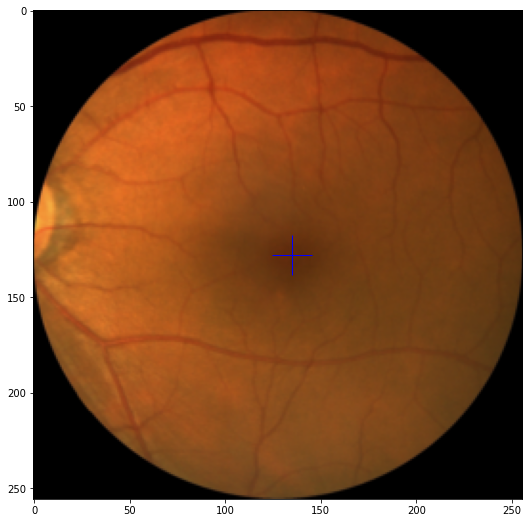

In [33]:
from torch.utils.data import Subset

train_ds = Subset(amd_ds1, train_index)
val_ds = Subset(amd_ds2, val_index)

# testing the AMDDataset to get some images from the dataset
def show(image, label = None):
    np_img = img.numpy().transpose((1, 2, 0))
    plt.imshow(np_img)

    if label is not None:
        label = rescale_label(label, img.shape[1:])
        print(label)
        x, y = label
        plt.plot(x, y, "b+", markersize=40)

# plt.figure(figsize=(5, 5))
for img, label in train_ds:
    show(img, label)
    break

In [34]:
# defining two dataloaders
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

for img_b, label_b in train_dl:
    print(img_b.shape, img_b.dtype)
    print(label_b)
    break

torch.Size([8, 3, 256, 256]) torch.float32
[tensor([0.5976, 0.6300, 0.5209, 0.6373, 0.4986, 0.5045, 0.5027, 0.4597],
       dtype=torch.float64), tensor([0.6605, 0.5951, 0.4981, 0.6614, 0.5054, 0.5145, 0.5623, 0.5117],
       dtype=torch.float64)]


### Creating the model